## Import

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [12]:
os.environ['CUDA_LAUNCH_BLOCKING']= '1'

In [13]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device= torch.device("cpu")
# device= "cpu"
print(device)

cpu


In [14]:
data_dir = "E:/trash_classification/modelAnalyze/data/Dataset"

In [15]:
img, lb= [], []
for i in os.listdir(data_dir):
  for j in os.listdir(os.path.join(data_dir, i)):
    img.append(os.path.join(data_dir, i, j))
    lb.append(i)

df= pd.DataFrame({'img_path': img, 'label': lb})

In [16]:
df.label= df.label.astype('int') - 1

In [17]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
dev_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [18]:
train_df.label.value_counts()

label
3    386
2    374
0    342
1    331
Name: count, dtype: int64

In [19]:
dev_df.label.value_counts()

label
1    38
0    31
2    29
3    28
Name: count, dtype: int64

In [20]:
test_df.label.value_counts()

label
0    35
3    33
1    31
2    28
Name: count, dtype: int64

In [21]:
arg= {
    'inp': 224,
    'bz': 64,
    'epoch': 20,
    # 'lr': 1.5e-3,
    'lr':5e-4,
    'required_grad': False
}

## 2. Data

In [22]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=30, shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=3, p=0.1),
    A.GaussNoise(p=0.2),
    A.MotionBlur(p=0.2),

    A.Resize(arg['inp'], arg['inp']),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


transform_dev= A.Compose([
    A.Resize(arg['inp'], arg['inp']),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [23]:
class ImageClassification(Dataset):
    def __init__(
        self,
        path_data: pd.DataFrame,
        transform= None
    ):

        self.path_data= path_data
        self.transform= transform



    def __len__(self):
        return len(self.path_data)

    def __getitem__(self, idx):
        image= cv2.imread(self.path_data.iloc[idx, 0])
        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image= self.transform(image= image)['image']

        return image, self.path_data.iloc[idx, -1]

data_train = ImageClassification(train_df, transform_train)
dataloader_train= DataLoader(data_train, batch_size= 64, shuffle= True )


data_dev = ImageClassification(dev_df, transform_dev)
dataloader_dev= DataLoader(data_dev, batch_size= 32, shuffle= True )

## 3. Model

In [24]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    # if isinstance(model, CrossEncoder) or isinstance(model, BiEncoder):
    #     params= model.parameters()
    # else:
    #     params= model.model.parameters()
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [25]:
class ResNetClassification(nn.Module):
  def __init__(self, dropout= 0.1):
      super().__init__()
      resnet= resnet50(weights= ResNet50_Weights.IMAGENET1K_V2)
      resnet.requires_grad_(True)
      self.encoder= nn.Sequential(*list(resnet.children()))[:-1]

      self.dropout= nn.Dropout(dropout)
      self.fc= nn.Linear(2048, 4)

  def forward(self, x):
    x= self.encoder(x).view(-1, 2048)
    x= self.dropout(x)
    return self.fc(x)


In [26]:
model= ResNetClassification()
model.to(device)
print_trainable_parameters(model)

trainable params: 23516228 || all params: 23516228 || trainable%: 100.0


## 4. Training

In [27]:
from transformers.optimization import get_linear_schedule_with_warmup

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
epochs= arg['epoch']

optimizer= torch.optim.Adam(model.parameters(), lr= arg['lr'])
criterion= nn.CrossEntropyLoss(label_smoothing= 0.1)

total_step= len(dataloader_train)
total_steps= total_step * epochs

scheduler= get_linear_schedule_with_warmup(optimizer, num_warmup_steps= 100, num_training_steps= total_steps)

In [29]:
def compute_f1_score(logits, labels):
    f1 = f1_score(labels.view(-1,).int().cpu().numpy(), logits.argmax(-1).view(-1,).cpu().numpy(), average='macro')
    return f1

In [30]:
from torch.cuda.amp import autocast, GradScaler
scaler= GradScaler()

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [31]:
history_loss= []
history_f1= []

val_history_loss= []
val_history_f1= []

In [32]:
def train_():
  total_acc, total_loss, total_count = 0, 0, 0
  for idx, (data, label) in enumerate(dataloader_train):
    model.train()
    with autocast():
      # print('data: {}'.format(data))
      # print('label: {}'.format(label))
      output= model(data.to(device, non_blocking= True))
      loss= criterion(output, label.to(device, dtype= torch.long, non_blocking= True))

    total_loss += loss.item()
    scaler.scale(loss).backward()

    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none= True)
    scheduler.step()

    model.eval()
    acc_step = compute_f1_score(output, label)
    total_acc += acc_step
    total_count += 1

    print(f'Epoch: [{epoch}/{epochs}], Step: [{idx+1}/{total_step}], loss: {loss.item()}, f1: {acc_step}')


  return total_acc/ total_count, total_loss / total_count

def evaluate(dataloader_data):
  model.eval()
  total_acc, total_loss, total_count= 0, 0, 0

  with torch.no_grad():
    for idx, (data, label) in enumerate(dataloader_data):
      output= model(data.to(device, non_blocking= True))
      loss= criterion(output, label.to(device, dtype= torch.long, non_blocking= True))

      total_loss += loss.item()
      total_acc += compute_f1_score(output, label)
      total_count += 1


  return total_acc/ total_count , total_loss/ total_count

In [33]:
log_acc= 0

for epoch in range(1, epochs + 1):
  train_acc, train_loss= train_()
  dev_acc, dev_loss= evaluate(dataloader_dev)

  history_loss.append(train_loss)
  history_f1.append(train_acc)

  val_history_loss.append(dev_loss)
  val_history_f1.append(dev_acc)

  print('-' * 59)
  print(f'End of epoch {epoch} - loss: {train_loss:.3f} - f1: {train_acc:.3f} - val_loss: {dev_loss:.3f} - val_f1: {dev_acc:.3f}')
  print('-' * 59)

  checkpoint = {
      'model_state_dict': model.state_dict(),
  }
  if dev_acc > log_acc:
    log_acc= dev_acc
    torch.save(checkpoint, f'E:/trash_classification/modelAnalyze/content/epoch_{train_acc:.3f}_{dev_acc:.3f}.bin')


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [1/23], loss: 1.394521713256836, f1: 0.2943181818181818


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [2/23], loss: 1.3917341232299805, f1: 0.22613636363636364


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [3/23], loss: 1.3904706239700317, f1: 0.26573878318064365


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [4/23], loss: 1.3835076093673706, f1: 0.2832217050967051


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [5/23], loss: 1.3942967653274536, f1: 0.27637570587528537


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [6/23], loss: 1.3807299137115479, f1: 0.34873240794293425


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [7/23], loss: 1.36537766456604, f1: 0.30875046006624957


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [8/23], loss: 1.3637690544128418, f1: 0.2838319088319088


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [9/23], loss: 1.3856258392333984, f1: 0.26610974610974614


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [10/23], loss: 1.3604146242141724, f1: 0.3961385836385836


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [11/23], loss: 1.3601957559585571, f1: 0.34892133512823165


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [12/23], loss: 1.3438736200332642, f1: 0.4046530977982591


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [13/23], loss: 1.3383957147598267, f1: 0.4791924244127234


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [14/23], loss: 1.2789225578308105, f1: 0.6731601731601731


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [15/23], loss: 1.3122938871383667, f1: 0.5861104328507134


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [16/23], loss: 1.288646936416626, f1: 0.5158329020757864


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [17/23], loss: 1.2747694253921509, f1: 0.551201290111247


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [18/23], loss: 1.2526367902755737, f1: 0.6515142921960072


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [19/23], loss: 1.2131059169769287, f1: 0.6696507515473032


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [20/23], loss: 1.1837769746780396, f1: 0.644147465437788


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [21/23], loss: 1.1559815406799316, f1: 0.6885512984457998


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [22/23], loss: 1.1515042781829834, f1: 0.6869692659166343


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [1/20], Step: [23/23], loss: 1.0979622602462769, f1: 0.7224358974358974
-----------------------------------------------------------
End of epoch 1 - loss: 1.307 - f1: 0.460 - val_loss: 1.064 - val_f1: 0.649
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [1/23], loss: 1.056867241859436, f1: 0.7333124303232998


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [2/23], loss: 1.0776245594024658, f1: 0.7704214559386974


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [3/23], loss: 1.0539437532424927, f1: 0.7379399585921325


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [4/23], loss: 1.0305814743041992, f1: 0.7220899470899471


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [5/23], loss: 0.9620863795280457, f1: 0.8525267152701489


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [6/23], loss: 0.9410602450370789, f1: 0.8117647058823529


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [7/23], loss: 0.9607086181640625, f1: 0.7569769602378298


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [8/23], loss: 0.8941290974617004, f1: 0.7940093067482339


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [9/23], loss: 0.8579409122467041, f1: 0.8226660726660727


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [10/23], loss: 0.7646924257278442, f1: 0.8785714285714286


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [11/23], loss: 0.744840681552887, f1: 0.8365490430622009


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [12/23], loss: 0.7050724625587463, f1: 0.9266541539476941


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [13/23], loss: 0.7057445645332336, f1: 0.853454415954416


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [14/23], loss: 0.6980535387992859, f1: 0.8115641668273247


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [15/23], loss: 0.8160579800605774, f1: 0.6934003496503497


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [16/23], loss: 0.6345635652542114, f1: 0.8306867875833394


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [17/23], loss: 0.613623321056366, f1: 0.8551051051051052


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [18/23], loss: 0.6082825660705566, f1: 0.9131856673407481


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [19/23], loss: 0.6034474968910217, f1: 0.8623348873348874


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [20/23], loss: 0.5914406776428223, f1: 0.8630515683147262


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [21/23], loss: 0.6121127605438232, f1: 0.8154440154440155


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [22/23], loss: 0.5427936315536499, f1: 0.928968253968254


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [2/20], Step: [23/23], loss: 0.5943474769592285, f1: 0.9249999999999999
-----------------------------------------------------------
End of epoch 2 - loss: 0.786 - f1: 0.826 - val_loss: 0.668 - val_f1: 0.884
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [1/23], loss: 0.5938354730606079, f1: 0.903003721424774


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [2/23], loss: 0.45926135778427124, f1: 0.9680527383367141


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [3/23], loss: 0.6167026162147522, f1: 0.8961769115442278


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [4/23], loss: 0.5959500074386597, f1: 0.8664956011730205


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [5/23], loss: 0.5370393395423889, f1: 0.919779857166427


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [6/23], loss: 0.49625498056411743, f1: 0.9199264615004326


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [7/23], loss: 0.4740173816680908, f1: 0.9490838864704563


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [8/23], loss: 0.4894508123397827, f1: 0.9348124098124098


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [9/23], loss: 0.48203516006469727, f1: 0.9388509755584283


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [10/23], loss: 0.6053545475006104, f1: 0.8438136188136188


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [11/23], loss: 0.6826890110969543, f1: 0.7685385338345865


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [12/23], loss: 0.45826831459999084, f1: 0.9843304843304843


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [13/23], loss: 0.548154890537262, f1: 0.8864631336405531


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [14/23], loss: 0.6323562860488892, f1: 0.8203431551230976


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [15/23], loss: 0.5029447674751282, f1: 0.9430362931080291


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [16/23], loss: 0.5641952753067017, f1: 0.923963133640553


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [17/23], loss: 0.5537639856338501, f1: 0.9102849660925886


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [18/23], loss: 0.464207261800766, f1: 0.9539627039627041


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [19/23], loss: 0.4762458801269531, f1: 0.9651442307692308


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [20/23], loss: 0.534309446811676, f1: 0.8954040077569488


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [21/23], loss: 0.46374425292015076, f1: 0.9508117164367165


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [22/23], loss: 0.414463073015213, f1: 0.9805097451274363


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [3/20], Step: [23/23], loss: 0.5347968339920044, f1: 0.9270833333333334
-----------------------------------------------------------
End of epoch 3 - loss: 0.530 - f1: 0.915 - val_loss: 0.470 - val_f1: 0.954
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [1/23], loss: 0.5881218314170837, f1: 0.8894071490845684


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [2/23], loss: 0.4841322898864746, f1: 0.9519175627240144


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [3/23], loss: 0.4442563056945801, f1: 0.9344418449197862


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [4/23], loss: 0.5445556640625, f1: 0.9043778801843319


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [5/23], loss: 0.455221951007843, f1: 0.9496163999340043


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [6/23], loss: 0.5102198123931885, f1: 0.917426249779191


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [7/23], loss: 0.44590556621551514, f1: 0.9372549019607843


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [8/23], loss: 0.5099158883094788, f1: 0.9235501486140872


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [9/23], loss: 0.5001425743103027, f1: 0.9356421356421356


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [10/23], loss: 0.511492908000946, f1: 0.8977886977886979


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [11/23], loss: 0.4671110510826111, f1: 0.9162238675958188


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [12/23], loss: 0.45901456475257874, f1: 0.9336961595026112


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [13/23], loss: 0.5074541568756104, f1: 0.9336996336996337


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [14/23], loss: 0.4317862391471863, f1: 0.9826762246117084


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [15/23], loss: 0.4436858594417572, f1: 0.9538009053269065


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [16/23], loss: 0.4856202006340027, f1: 0.90625


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [17/23], loss: 0.4761351943016052, f1: 0.9699477351916377


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [18/23], loss: 0.43724489212036133, f1: 0.9616477272727273


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [19/23], loss: 0.4568623900413513, f1: 0.9308200017484045


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [20/23], loss: 0.4451942443847656, f1: 0.9501750700280112


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [21/23], loss: 0.42670345306396484, f1: 0.9593597262952102


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [22/23], loss: 0.5311121940612793, f1: 0.8985497835497835


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [4/20], Step: [23/23], loss: 0.6306489706039429, f1: 0.8692564745196324
-----------------------------------------------------------
End of epoch 4 - loss: 0.487 - f1: 0.931 - val_loss: 0.667 - val_f1: 0.868
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [1/23], loss: 0.5386863946914673, f1: 0.9116542440071851


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [2/23], loss: 0.6133080720901489, f1: 0.8787087912087912


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [3/23], loss: 0.548358678817749, f1: 0.9069390826408428


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [4/23], loss: 0.49984830617904663, f1: 0.9356676003734827


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [5/23], loss: 0.5119468569755554, f1: 0.911437908496732


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [6/23], loss: 0.5169364809989929, f1: 0.9073821339950372


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [7/23], loss: 0.5531123280525208, f1: 0.882545615304236


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [8/23], loss: 0.585839569568634, f1: 0.9236878216123499


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [9/23], loss: 0.4740276336669922, f1: 0.920995670995671


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [10/23], loss: 0.49753063917160034, f1: 0.9311274509803921


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [11/23], loss: 0.47109729051589966, f1: 0.9335539012958368


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [12/23], loss: 0.5449215173721313, f1: 0.9011363636363636


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [13/23], loss: 0.4863927364349365, f1: 0.9130642570950658


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [14/23], loss: 0.3963925242424011, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [15/23], loss: 0.558387815952301, f1: 0.9197224344283168


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [16/23], loss: 0.4868510961532593, f1: 0.9063707247917774


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [17/23], loss: 0.43612930178642273, f1: 0.9501750700280112


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [18/23], loss: 0.470488578081131, f1: 0.9852813852813853


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [19/23], loss: 0.470694363117218, f1: 0.9405296824651663


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [20/23], loss: 0.5070677399635315, f1: 0.9211278195488721


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [21/23], loss: 0.4534124732017517, f1: 0.9698996655518395


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [22/23], loss: 0.46350058913230896, f1: 0.9517992424242425


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [5/20], Step: [23/23], loss: 0.6491549015045166, f1: 0.8494152046783625
-----------------------------------------------------------
End of epoch 5 - loss: 0.510 - f1: 0.924 - val_loss: 0.535 - val_f1: 0.906
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [1/23], loss: 0.4716704785823822, f1: 0.9230541024895863


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [2/23], loss: 0.44866520166397095, f1: 0.9550238473767885


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [3/23], loss: 0.4051865339279175, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [4/23], loss: 0.41000282764434814, f1: 0.9826762246117084


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [5/23], loss: 0.4504253566265106, f1: 0.9679558869214042


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [6/23], loss: 0.4263084828853607, f1: 0.9679494698849538


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [7/23], loss: 0.4719567596912384, f1: 0.9533404217614744


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [8/23], loss: 0.48360180854797363, f1: 0.9217066298660227


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [9/23], loss: 0.4447184205055237, f1: 0.9705882352941176


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [10/23], loss: 0.49207940697669983, f1: 0.9214618714618714


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [11/23], loss: 0.39375782012939453, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [12/23], loss: 0.4397580623626709, f1: 0.9856386999244142


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [13/23], loss: 0.4564360976219177, f1: 0.9840283939662822


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [14/23], loss: 0.43856513500213623, f1: 0.9213368105863035


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [15/23], loss: 0.46556347608566284, f1: 0.925


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [16/23], loss: 0.558120608329773, f1: 0.8923648931713447


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [17/23], loss: 0.560905933380127, f1: 0.9291896144767899


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [18/23], loss: 0.47041231393814087, f1: 0.9366933435898952


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [19/23], loss: 0.5490010380744934, f1: 0.8876851851851851


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [20/23], loss: 0.4780682623386383, f1: 0.9238277686553548


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [21/23], loss: 0.4576745331287384, f1: 0.9874921826141339


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [22/23], loss: 0.4236055612564087, f1: 0.9583645911477869


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [6/20], Step: [23/23], loss: 0.5207591652870178, f1: 0.9495798319327731
-----------------------------------------------------------
End of epoch 6 - loss: 0.466 - f1: 0.950 - val_loss: 0.602 - val_f1: 0.852
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [1/23], loss: 0.5014675855636597, f1: 0.9462710831131884


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [2/23], loss: 0.45573243498802185, f1: 0.9519852882624622


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [3/23], loss: 0.5256385803222656, f1: 0.8993055555555556


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [4/23], loss: 0.4396091103553772, f1: 0.951948051948052


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [5/23], loss: 0.4375414252281189, f1: 0.9538530465949822


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [6/23], loss: 0.3890847861766815, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [7/23], loss: 0.3755466639995575, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [8/23], loss: 0.4160849452018738, f1: 0.9688194444444445


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [9/23], loss: 0.44775721430778503, f1: 0.9550219076508257


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [10/23], loss: 0.4699387550354004, f1: 0.9359780370624571


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [11/23], loss: 0.4541209936141968, f1: 0.9508572567783093


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [12/23], loss: 0.5007444620132446, f1: 0.9152335858585858


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [13/23], loss: 0.5817126631736755, f1: 0.9022435897435899


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [14/23], loss: 0.44310474395751953, f1: 0.9676550633072372


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [15/23], loss: 0.4552910625934601, f1: 0.9696428571428573


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [16/23], loss: 0.43101996183395386, f1: 0.9674369747899161


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [17/23], loss: 0.4434531033039093, f1: 0.9683437102791942


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [18/23], loss: 0.4748998284339905, f1: 0.9527093596059113


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [19/23], loss: 0.42662447690963745, f1: 0.9681340370995544


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [20/23], loss: 0.4308502674102783, f1: 0.932936507936508


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [21/23], loss: 0.46138858795166016, f1: 0.9529123608903021


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [22/23], loss: 0.4413413405418396, f1: 0.9682539682539684


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [7/20], Step: [23/23], loss: 0.4007664620876312, f1: 1.0
-----------------------------------------------------------
End of epoch 7 - loss: 0.452 - f1: 0.956 - val_loss: 0.419 - val_f1: 0.974
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [1/23], loss: 0.4689726233482361, f1: 0.9392204704704704


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [2/23], loss: 0.44859352707862854, f1: 0.9485714285714285


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [3/23], loss: 0.39062023162841797, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [4/23], loss: 0.41741761565208435, f1: 0.9842364532019705


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [5/23], loss: 0.40894025564193726, f1: 0.9668728272293637


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [6/23], loss: 0.42338287830352783, f1: 0.9724702380952381


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [7/23], loss: 0.4687007665634155, f1: 0.932979301400354


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [8/23], loss: 0.41914743185043335, f1: 0.9682692307692308


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [9/23], loss: 0.45556026697158813, f1: 0.9513700738916256


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [10/23], loss: 0.42088285088539124, f1: 0.9678081629301141


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [11/23], loss: 0.45388397574424744, f1: 0.9370039682539684


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [12/23], loss: 0.4273006021976471, f1: 0.9696600147819661


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [13/23], loss: 0.4913088083267212, f1: 0.9351537175066587


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [14/23], loss: 0.5318031311035156, f1: 0.9363799283154122


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [15/23], loss: 0.44319188594818115, f1: 0.9371060924369747


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [16/23], loss: 0.404374897480011, f1: 0.9819875776397515


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [17/23], loss: 0.43710488080978394, f1: 0.9846225535880708


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [18/23], loss: 0.468123197555542, f1: 0.9384995791245792


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [19/23], loss: 0.4669724702835083, f1: 0.9522727272727274


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [20/23], loss: 0.4979221224784851, f1: 0.903580866807611


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [21/23], loss: 0.4588995575904846, f1: 0.9506283945939118


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [22/23], loss: 0.44650986790657043, f1: 0.9507575757575757


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [8/20], Step: [23/23], loss: 0.42529749870300293, f1: 0.9590643274853801
-----------------------------------------------------------
End of epoch 8 - loss: 0.447 - f1: 0.955 - val_loss: 0.415 - val_f1: 0.979
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [1/23], loss: 0.466094970703125, f1: 0.9508597883597882


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [2/23], loss: 0.4771714210510254, f1: 0.9503593546907256


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [3/23], loss: 0.43717965483665466, f1: 0.9687531460787275


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [4/23], loss: 0.41210058331489563, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [5/23], loss: 0.43242159485816956, f1: 0.9684261063571409


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [6/23], loss: 0.41227811574935913, f1: 0.9694444444444444


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [7/23], loss: 0.43492937088012695, f1: 0.9688838612368025


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [8/23], loss: 0.3916158974170685, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [9/23], loss: 0.42884325981140137, f1: 0.9682539682539684


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [10/23], loss: 0.44173651933670044, f1: 0.9785373608903021


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [11/23], loss: 0.4059060215950012, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [12/23], loss: 0.3887801468372345, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [13/23], loss: 0.4211149215698242, f1: 0.947081579703531


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [14/23], loss: 0.4475319981575012, f1: 0.9661268411268411


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [15/23], loss: 0.41571128368377686, f1: 0.9857142857142858


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [16/23], loss: 0.4089911878108978, f1: 0.9491965566714491


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [17/23], loss: 0.46548569202423096, f1: 0.9503571428571429


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [18/23], loss: 0.409490168094635, f1: 0.9667663476874003


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [19/23], loss: 0.373979777097702, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [20/23], loss: 0.41953814029693604, f1: 0.9667832167832169


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [21/23], loss: 0.42755621671676636, f1: 0.9861215303825956


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [22/23], loss: 0.4118451476097107, f1: 0.967967967967968


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [9/20], Step: [23/23], loss: 0.49316203594207764, f1: 0.9097222222222222
-----------------------------------------------------------
End of epoch 9 - loss: 0.427 - f1: 0.970 - val_loss: 0.431 - val_f1: 0.969
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [1/23], loss: 0.41496556997299194, f1: 0.9819354838709677


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [2/23], loss: 0.39658600091934204, f1: 0.9833147942157954


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [3/23], loss: 0.4310383200645447, f1: 0.9676113360323886


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [4/23], loss: 0.4204181134700775, f1: 0.9724702380952381


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [5/23], loss: 0.38147711753845215, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [6/23], loss: 0.4059083163738251, f1: 0.9849690539345712


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [7/23], loss: 0.4468427300453186, f1: 0.9175820355951056


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [8/23], loss: 0.4377210736274719, f1: 0.9691676267281106


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [9/23], loss: 0.4174745976924896, f1: 0.9675828460038987


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [10/23], loss: 0.423373281955719, f1: 0.971875


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [11/23], loss: 0.41314637660980225, f1: 0.9709037378392217


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [12/23], loss: 0.44150233268737793, f1: 0.9712962962962963


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [13/23], loss: 0.4032517373561859, f1: 0.9583333333333333


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [14/23], loss: 0.405215322971344, f1: 0.9682692307692309


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [15/23], loss: 0.38558030128479004, f1: 0.986013986013986


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [16/23], loss: 0.37922823429107666, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [17/23], loss: 0.4380200505256653, f1: 0.9704861111111112


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [18/23], loss: 0.43616873025894165, f1: 0.9669143648921201


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [19/23], loss: 0.43707171082496643, f1: 0.9580419580419581


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [20/23], loss: 0.3892930746078491, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [21/23], loss: 0.4389221668243408, f1: 0.9682838481503666


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [22/23], loss: 0.3907700777053833, f1: 0.9864468864468865


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [10/20], Step: [23/23], loss: 0.42584845423698425, f1: 0.9511278195488722
-----------------------------------------------------------
End of epoch 10 - loss: 0.416 - f1: 0.973 - val_loss: 0.403 - val_f1: 0.972
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [1/23], loss: 0.4868950843811035, f1: 0.9238942307692308


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [2/23], loss: 0.415815144777298, f1: 0.9833164812942365


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [3/23], loss: 0.3645751178264618, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [4/23], loss: 0.3790765404701233, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [5/23], loss: 0.4545865058898926, f1: 0.9692663476874003


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [6/23], loss: 0.38461747765541077, f1: 0.9819354838709677


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [7/23], loss: 0.5024439096450806, f1: 0.9497297297297297


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [8/23], loss: 0.4275451898574829, f1: 0.9701568994789532


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [9/23], loss: 0.3816774785518646, f1: 0.9826762246117084


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [10/23], loss: 0.4011654853820801, f1: 0.98380355276907


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [11/23], loss: 0.4234413802623749, f1: 0.9678030303030303


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [12/23], loss: 0.4245549142360687, f1: 0.9686202067033711


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [13/23], loss: 0.36940401792526245, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [14/23], loss: 0.37810030579566956, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [15/23], loss: 0.43014413118362427, f1: 0.9653310104529618


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [16/23], loss: 0.3870979845523834, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [17/23], loss: 0.37343740463256836, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [18/23], loss: 0.371064156293869, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [19/23], loss: 0.39216166734695435, f1: 0.9852813852813853


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [20/23], loss: 0.4089033901691437, f1: 0.968864468864469


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [21/23], loss: 0.3977474570274353, f1: 0.9640857120634674


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [22/23], loss: 0.415722131729126, f1: 0.9555555555555555


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [11/20], Step: [23/23], loss: 0.4001474678516388, f1: 1.0
-----------------------------------------------------------
End of epoch 11 - loss: 0.407 - f1: 0.979 - val_loss: 0.387 - val_f1: 0.984
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [1/23], loss: 0.4235130548477173, f1: 0.9535095579450419


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [2/23], loss: 0.3973734974861145, f1: 0.9819354838709677


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [3/23], loss: 0.3796388506889343, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [4/23], loss: 0.37281548976898193, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [5/23], loss: 0.3932237923145294, f1: 0.9833164812942365


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [6/23], loss: 0.3640514016151428, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [7/23], loss: 0.40274566411972046, f1: 0.9843597262952102


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [8/23], loss: 0.39252936840057373, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [9/23], loss: 0.41878578066825867, f1: 0.9819976771196284


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [10/23], loss: 0.4068436324596405, f1: 0.9530791788856305


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [11/23], loss: 0.36537671089172363, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [12/23], loss: 0.39409536123275757, f1: 0.9842364532019705


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [13/23], loss: 0.4278907775878906, f1: 0.9578804347826086


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [14/23], loss: 0.43100056052207947, f1: 0.9520388176638177


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [15/23], loss: 0.3690391182899475, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [16/23], loss: 0.4038770794868469, f1: 0.9735054347826086


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [17/23], loss: 0.3985465466976166, f1: 0.9863266814486327


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [18/23], loss: 0.39135393500328064, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [19/23], loss: 0.37013381719589233, f1: 0.9827586206896552


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [20/23], loss: 0.37556537985801697, f1: 0.982373678025852


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [21/23], loss: 0.3826432526111603, f1: 0.9815546772068511


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [22/23], loss: 0.3619571030139923, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [12/20], Step: [23/23], loss: 0.4136863350868225, f1: 0.957516339869281
-----------------------------------------------------------
End of epoch 12 - loss: 0.393 - f1: 0.982 - val_loss: 0.404 - val_f1: 0.970
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [1/23], loss: 0.37225571274757385, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [2/23], loss: 0.3932449519634247, f1: 0.9856674856674856


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [3/23], loss: 0.3854227662086487, f1: 0.985178727114211


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [4/23], loss: 0.4246949553489685, f1: 0.965128957064441


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [5/23], loss: 0.4118656516075134, f1: 0.9733893557422969


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [6/23], loss: 0.39816391468048096, f1: 0.9680358699713538


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [7/23], loss: 0.39154142141342163, f1: 0.9681340370995544


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [8/23], loss: 0.38914209604263306, f1: 0.9828571428571429


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [9/23], loss: 0.3761914074420929, f1: 0.9848484848484849


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [10/23], loss: 0.3618803322315216, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [11/23], loss: 0.40018707513809204, f1: 0.9768421052631578


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [12/23], loss: 0.39468586444854736, f1: 0.9852813852813853


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [13/23], loss: 0.38471901416778564, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [14/23], loss: 0.3656289577484131, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [15/23], loss: 0.4244017004966736, f1: 0.9541025641025642


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [16/23], loss: 0.3833204507827759, f1: 0.9805194805194806


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [17/23], loss: 0.39721062779426575, f1: 0.9688986901897889


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [18/23], loss: 0.3622264266014099, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [19/23], loss: 0.3871840536594391, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [20/23], loss: 0.41227054595947266, f1: 0.9855653568564555


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [21/23], loss: 0.3904535472393036, f1: 0.9807407407407407


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [22/23], loss: 0.3684847950935364, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [13/20], Step: [23/23], loss: 0.36411070823669434, f1: 1.0
-----------------------------------------------------------
End of epoch 13 - loss: 0.389 - f1: 0.985 - val_loss: 0.385 - val_f1: 0.984
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [1/23], loss: 0.4243117570877075, f1: 0.9603174603174603


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [2/23], loss: 0.3984740078449249, f1: 0.9540441176470589


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [3/23], loss: 0.3680429458618164, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [4/23], loss: 0.367245078086853, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [5/23], loss: 0.385040283203125, f1: 0.9810281517747858


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [6/23], loss: 0.4009389579296112, f1: 0.9830328738069989


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [7/23], loss: 0.36341094970703125, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [8/23], loss: 0.3788416385650635, f1: 0.9827201783723523


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [9/23], loss: 0.36671382188796997, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [10/23], loss: 0.3723454475402832, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [11/23], loss: 0.38252267241477966, f1: 0.9800307219662059


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [12/23], loss: 0.4066736102104187, f1: 0.9718890554722639


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [13/23], loss: 0.38596272468566895, f1: 0.9847926267281106


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [14/23], loss: 0.36167606711387634, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [15/23], loss: 0.3974212408065796, f1: 0.9671456822676334


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [16/23], loss: 0.3641500473022461, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [17/23], loss: 0.36771664023399353, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [18/23], loss: 0.3651590347290039, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [19/23], loss: 0.38146519660949707, f1: 0.9864864864864864


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [20/23], loss: 0.36958178877830505, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [21/23], loss: 0.3908776640892029, f1: 0.9685373608903021


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [22/23], loss: 0.363029420375824, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [14/20], Step: [23/23], loss: 0.3837984800338745, f1: 1.0
-----------------------------------------------------------
End of epoch 14 - loss: 0.380 - f1: 0.988 - val_loss: 0.387 - val_f1: 0.993
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [1/23], loss: 0.3624325096607208, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [2/23], loss: 0.40800410509109497, f1: 0.9830328738069989


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [3/23], loss: 0.36459314823150635, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [4/23], loss: 0.45441699028015137, f1: 0.9405433219263006


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [5/23], loss: 0.3952619433403015, f1: 0.9613095238095237


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [6/23], loss: 0.3790361285209656, f1: 0.9861003861003861


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [7/23], loss: 0.3656982183456421, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [8/23], loss: 0.388852059841156, f1: 0.9816849816849816


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [9/23], loss: 0.3638467788696289, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [10/23], loss: 0.3793695569038391, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [11/23], loss: 0.40270236134529114, f1: 0.982373678025852


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [12/23], loss: 0.41552960872650146, f1: 0.9594570135746606


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [13/23], loss: 0.37158387899398804, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [14/23], loss: 0.35898327827453613, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [15/23], loss: 0.3732612729072571, f1: 0.9843597262952102


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [16/23], loss: 0.37718087434768677, f1: 0.9864468864468865


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [17/23], loss: 0.3699270486831665, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [18/23], loss: 0.3670174479484558, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [19/23], loss: 0.3640870749950409, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [20/23], loss: 0.3800249993801117, f1: 0.9814814814814814


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [21/23], loss: 0.4212397336959839, f1: 0.9815229563269876


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [22/23], loss: 0.44213372468948364, f1: 0.9686635944700461


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [15/20], Step: [23/23], loss: 0.3635789752006531, f1: 1.0
-----------------------------------------------------------
End of epoch 15 - loss: 0.386 - f1: 0.987 - val_loss: 0.372 - val_f1: 1.000
-----------------------------------------------------------


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [1/23], loss: 0.387068510055542, f1: 0.9830328738069989


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [2/23], loss: 0.43228912353515625, f1: 0.9335375026864389


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [3/23], loss: 0.3628430962562561, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [4/23], loss: 0.361718088388443, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [5/23], loss: 0.3756890296936035, f1: 0.9847926267281106


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [6/23], loss: 0.35852745175361633, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [7/23], loss: 0.40190231800079346, f1: 0.9739304812834224


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [8/23], loss: 0.35836076736450195, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [9/23], loss: 0.3632963299751282, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [10/23], loss: 0.36307162046432495, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [11/23], loss: 0.36336979269981384, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [12/23], loss: 0.41310960054397583, f1: 0.9533333333333334


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [13/23], loss: 0.364762544631958, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [14/23], loss: 0.37280938029289246, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [15/23], loss: 0.37057363986968994, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [16/23], loss: 0.37449711561203003, f1: 0.9847926267281106


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [17/23], loss: 0.3869660496711731, f1: 0.985178727114211


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [18/23], loss: 0.36630526185035706, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [19/23], loss: 0.3853425979614258, f1: 0.9833164812942365


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [20/23], loss: 0.364978164434433, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [21/23], loss: 0.3628186881542206, f1: 1.0


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [22/23], loss: 0.3962973952293396, f1: 0.9856674856674856


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [16/20], Step: [23/23], loss: 0.3743368685245514, f1: 1.0
-----------------------------------------------------------
End of epoch 16 - loss: 0.377 - f1: 0.990 - val_loss: 0.374 - val_f1: 1.000
-----------------------------------------------------------


KeyboardInterrupt: 

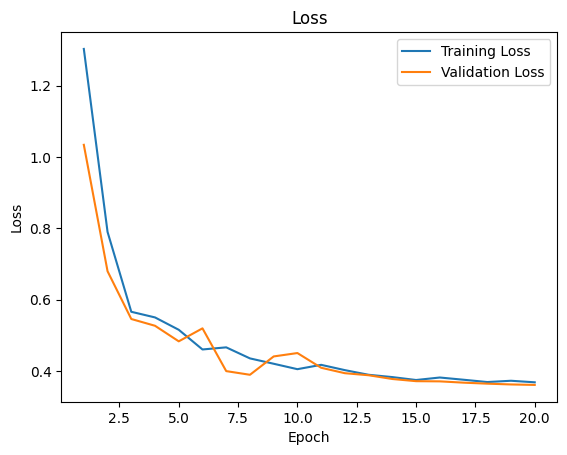

In [ ]:
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(range(1, len(history_loss)+1), history_loss, label='Training Loss')
plt.plot(range(1, len(val_history_loss)+1), val_history_loss, label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
plt.title('F1-score')
plt.xlabel("Epoch")
plt.ylabel("F1-score")

# Plot training F1-score
plt.plot(range(1, len(history_f1) + 1), history_f1, label='Training F1-score')

# Plot validation F1-score
plt.plot(range(1, len(val_history_f1) + 1), val_history_f1, label='Validation F1-score')

plt.legend()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
model.load_state_dict(torch.load('E:/trash_classification/modelAnalyze/content/epoch_0.948_1.000.bin')['model_state_dict'])

NameError: name 'ResNetClassification' is not defined

In [ ]:
data_test = ImageClassification(test_df, transform_dev)
dataloader_test= DataLoader(data_test, batch_size= 32, shuffle= True )

In [ ]:
evaluate(dataloader_test)